<a href="https://colab.research.google.com/github/ShreyashDhoot/learning-pytorch/blob/main/Pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Running tensors and PyTorch objects on the GPU

In [34]:
import torch
import numpy as np

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# check for GPU access with pytorch
torch.cuda.is_available()

False

In [4]:
### Setup device agnostic code
###Best practice runs on GPU if available or runs on cpu
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
torch.cuda.device_count()

0

##### putting tensors and models on GPU

In [6]:
#create a Tensor
tensor=torch.tensor([1,2,3],device="cpu") # cpu by default
print(tensor,tensor.device)

tensor([1, 2, 3]) cpu


In [7]:
#move tensor to GPU
tensor_on_gpu=tensor.to(device)
print(tensor,tensor_on_gpu.device)

tensor([1, 2, 3]) cpu


In [8]:
## Moving tensors back to cpu -> numpy only works on CPU
tensor_on_cpu=tensor_on_gpu.to("cpu")
print(tensor_on_cpu,tensor_on_cpu.device)
tensor_to_numpy=tensor_on_cpu.numpy()
print(tensor_to_numpy)

tensor([1, 2, 3]) cpu
[1 2 3]


### Pytorch Workflow

an example for end to end workflow using PyTorch

In [9]:
from torch import nn ## all the building blocks for neural networks
import matplotlib.pyplot as plt

## 1. Data (preparing and loading)

Let's create data using linear regression formula.

In [10]:
# Create *known* parameters
weight=0.7
bias=0.3

#create
start=0
end=1
step=0.02
X=torch.arange(start,end,step).unsqueeze(dim=1) #adds and extra dimension
#Regression Formula
y= weight * X + bias

In [11]:
len(X),len(y)

(50, 50)

In [12]:
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

####splitting the data into train,test sets

In [13]:
train_split=int(0.8*len(X))
X_train,y_train=X[:train_split],y[:train_split]
X_test,y_test=X[train_split:],y[train_split:]
### Scikit learns Train - Test split can be used

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

#### Visualizing the training and testing data

In [14]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  plots train data and predictions
  """
  plt.figure(figsize=(10,7))
  plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")
  plt.scatter(test_data,test_labels,c="r",s=4,label="test data")
  if predictions is not None:
    plt.scatter(test_data,predictions,c="g",s=4,label="Predictions")
  plt.legend(prop={"size":14});

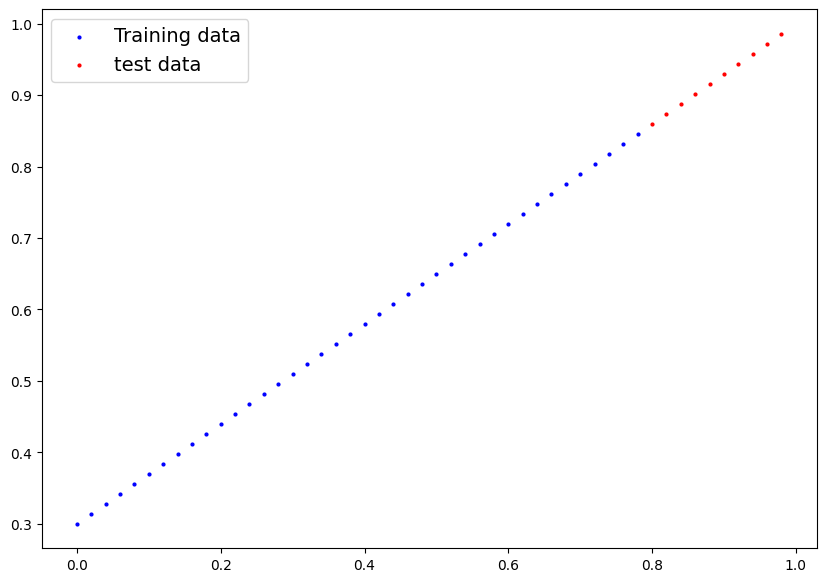

In [15]:
plot_predictions();

## 2. Building a model

In [26]:
#Create linear regression models class
#class inherits from nn.Module
class LinearRegressionModel(nn.Module): #<- almost everything inherits from nn.Module in PyTorch
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias= nn.Parameter(torch.randn(1,
                                       requires_grad=True, #<- for Gradient descent
                                       dtype=torch.float))
    # forward defines computation that happens at every call and is compulsory for each custom subclass of nn.Module
  def forward(self,x:torch.Tensor)-> torch.Tensor: #<-"x" is the input data
    return self.weights * x + self.bias # this is the linear regression

PyTorch model building essentials
* torch.nn - contains all the building blocks for computational graphs
* nn.Parameters - What parameters should our model try and learn often a PyTorch later form torch.nn will set this for us
* torch.nn.Module - base class for all neural network modules. if you subclass it you should override forward()
* torch.optim - this is where PyTorch optimizers live eg- Adam optimizer

### Checking contents of our model

In [47]:
# create a random seed
random_seed=42
torch.manual_seed(random_seed)
# create an instance of our model
model_0=LinearRegressionModel()
#check out parameters
print(list(model_0.parameters()))
print("-----------------------------------------------")
# List named parameters
model_0.state_dict()

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
-----------------------------------------------


OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using `torch.inference_mode()`

To check out models prediction power and see how well it predicts y_test on X_test

y-prediction 

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])
-----------------------
difference in test and prediction 
 
tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])


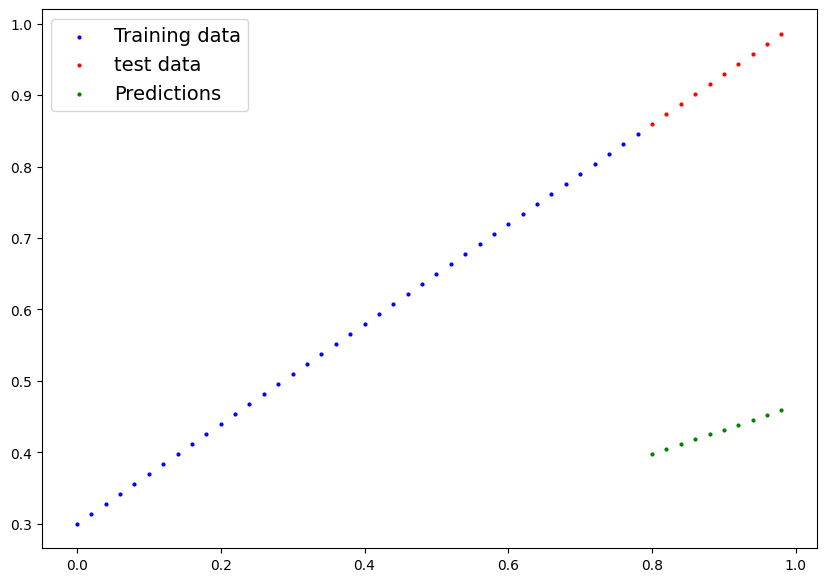

In [48]:
# making prediction or inference using our model
with torch.inference_mode(): # <-disables gradient tracking as not needed during inference => faster prediction
  y_preds=model_0(X_test)

# alternative to inference mode
'''
with torch.no_grad():
  y_preds=model_0(X_test)
'''

print("y-prediction \n")
print(y_preds)
print("-----------------------")
print("difference in test and prediction \n ")
print(y_test-y_preds)
plot_predictions(predictions=y_preds)

## 3.Train Model

moving from unknown parameters to known parameters i.e from a poor representation of data to good representation of data

* model performance can be guaged by using loss function



###### Things we need to train
* Loss function
* Optimizer

In [59]:
#setup a loss function
loss_fn=nn.L1Loss()

#setup a optimizer (stochastic gradient descent)
optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.01)  # <-lr= learning rate

In [60]:
torch.manual_seed(42)
#Building a Training Loop
epochs=200

#Track different values
epoch_count=[]
loss_values=[]
test_loss_values=[]

# Loop through the data
for epoch in range (epochs):
  #set the model to training mode
  model_0.train() # train mode in PyTorch sets gradients=True for all parameters that require it

  # 1. forward pass
  y_pred=model_0(X_train)

  # 2. calculate the loss (MAE)
  loss=loss_fn(y_pred,y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. perform backprop on the loss with respect to the parameters of the model
  loss.backward()

  # 5. step the optimizer (perform gradient descent)
  optimizer.step() # <- by default how the optimizer chnages will accumulate through the loop so we have to zero them above in step 3

  ## Testing code
  model_0.eval() #turns of settings in the model not needed for evaluation(drop-out,batch norm)
  with torch.inference_mode():
    # 1. forward pass
    test_pred=model_0(X_test)

    # 2. calculate the loss
    test_loss=loss_fn(test_pred,y_test)
  if epoch % 10==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss : {test_loss} \n")
    print("----------------------------------------------------------")

Epoch: 0 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 10 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 20 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 30 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 40 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 50 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 60 | Loss: 0.008932482451200485 | Test Loss : 0.005023092031478882 

----------------------------------------------------------
Epoch: 70 | Loss: 0.008932482451200485 | Test Loss : 0.0

In [61]:
with torch.inference_mode():
    y_preds_new=model_0(X_test)

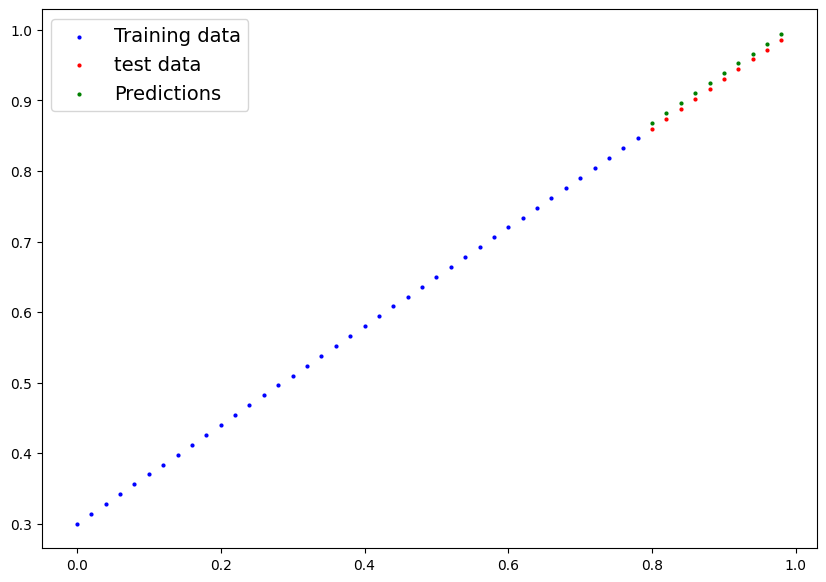

In [62]:
plot_predictions(predictions=y_preds_new)

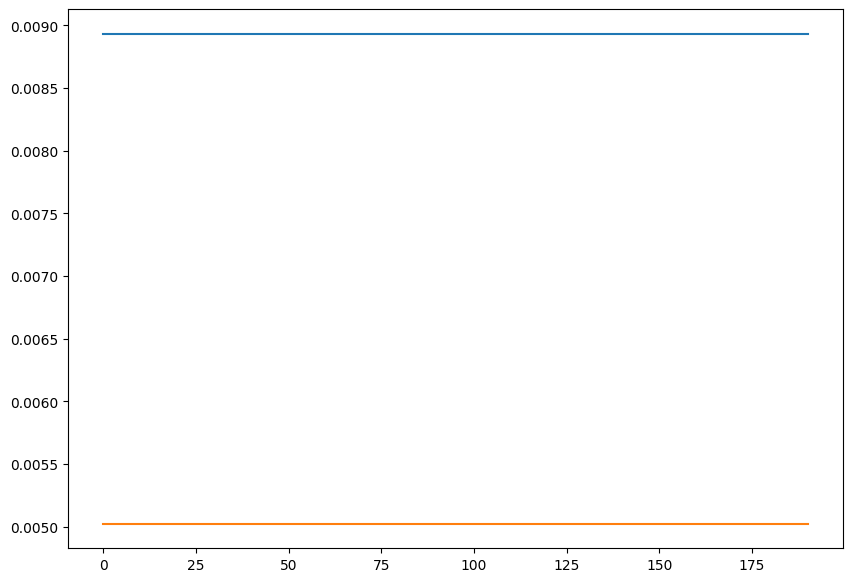

In [63]:
#plot loss curves
plt.figure(figsize=(10,7))
# here loss_values are tensors thus we need to convert it to np array because of matplotlib
plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()),label="train_loss")
# test_loss_value dont give error as they are calculated while the inference mode was turned off
plt.plot(epoch_count,test_loss_values,label="test_loss")

## 4. Saving a Model in PyTorch

### Three main methods

1. `torch.save()` - saves in pickle file format
2. `torch.load()` - allows you to load a saved Pytorch object
3. `torch.nn.Module.load_state_dict()` - this allows to save a model's saved state dictionary

In [56]:
# Saving our PyTorch model

from pathlib import Path

# 1.create a model directory
MODEL_PATH=Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_model.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"save model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

save model to models/01_pytorch_model.pth


## 5. Loading a PyTorch model

In [57]:
# to load in a saved state_dict we have to instentiate a new instance of our model class
loaded_model_0=LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [58]:
loaded_model_0.state_dict(),model_0.state_dict()

(OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]),
 OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))]))